In [9]:
from PIL import Image  # this contain the image class and methods from PIL library
import numpy as np # this imports the numerical and array library 
import cv2
import matplotlib.pyplot as plt
from skimage import measure
import math
import scipy
import os
from collections import Counter

# Change file directory path here
All the results will be stored in cw_data directory.

In [10]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Colab Notebooks/cs413/cw_data/DATA/"
try:
  results_dir = "/content/drive/MyDrive/Colab Notebooks/cs413/cw_data/results/"
  os.mkdir(results_dir)
except:
  pass


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
def bounding_box(comps, label=1): # returns bounding boxes of a component in an image
    
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

    # mask/select by where value is given label (component)
    where_x = xx[comps==label]
    where_y = yy[comps==label]
    
    # find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)

# Image Extractor
(Extracts all the images from a training image)\
It uses bounding boxes on the components to extract an image
Made efficient by removing all the unwanted components using counter function

In [12]:
# Returns a list of all the cards in a training image

def image_extracter(comps,im_gray,im):

  unique = sorted([i[0] for i in Counter(list(comps.ravel())).most_common(25)])# unique labels 

  min_size = 100000 # minimum pixel size threshold
  thres_size = 500000 # Average max pixel size of a card
  max_size = 1500000 # Max Average pixel size of any component.
  bounding_boxes = []
  component_images = [] # list of component images

  for l in unique[1:]: # we know label 0 is always the entire image, so, sliced the list from 1.
      bb = bounding_box(comps, label=l)
      # make a binary image for each component
      one_comp = np.zeros(im.shape[0:2], dtype='uint8')
      one_comp[comps==l] = 1


      # measure its size
      n = np.count_nonzero(one_comp)
      # plot as image if it's big enough
      if (n>min_size) & (n< max_size):
          card_image = []
          if n <= thres_size:

            req_card = im[bb[1]:bb[3],bb[0]:bb[2]]

            #bounding_boxes.append(bb)
            card_image.append(req_card)
            component_images += card_image 
            print('label ', l,'component size is ', n)
            
            plt.imshow(cv2.cvtColor(req_card, cv2.COLOR_BGR2RGB))
            plt.show()
          # Further breaks the components which were left with more than one cards attached, by reducing the threshold further (from 248 to 205)
          # thres_size is used to locate such components which has more than one cards combined.
          else: 
            im_mrthan1 = im_gray[bb[1]:bb[3],bb[0]:bb[2]] 
            img_mrthan1c = im[bb[1]:bb[3],bb[0]:bb[2]]
            threshed_mr1 = np.zeros(im_mrthan1.shape, 'int')
            threshed_mr1[(im_mrthan1<205)] = 1
            comp_mrt1 = measure.label(threshed_mr1,background=0)
            component_images += image_extracter(comp_mrt1,im_mrthan1,img_mrthan1c) # uses recursion to extracts the cards from those comps.

  return component_images

Labels are in the order of the training image sequence ( 002 - 014 ) 

In [13]:
# Labels extracted manually in the same order as the sequential order of training image i.e.(train-002 to train-014)
l1 = "067,035,040,005,018,052,031,033,047,052,210,033,054,063,036,026,033,048".split(",")
l2 = "017,073,057,057,054,089,060,066,054,057,076,033,068,025,068,033,063,083".split(",")
l3 = "056,065,036,044,089,004,096,015,059,015,063,011,069,001,089,001,062,056".split(",")
l4 = "089,054,073,017,057,057,076,057,054,068,066,033,060,063,033,025,083,068".split(",")
l5 = "054,031,026,033,048,036,052,067,052,210,047,047,033,035,033,040,018,063,005".split(",")
l6 = "092,011,007,063,096,054,042,082,024,045,037,011,098,021,065,028,002,024".split(",")
l7 = "177,160,150,192,161,087,138,164,183,124,104,190,101,135,115,142,168,114".split(",")
l8 = "147,139,136,109,129,186,106,146,182,109,154,108,198,151,127,189,108,146".split(",")
l9 = "192,174,198,196,103,134,114,190,182,147,154,192,142,146,148,133,174,191".split(",")
l10 ="182,172,171,133,134,120,181,139,172,189,156,181,111,106,156,184,139,131".split(",")
l11 ="139,139,162,165,150,121,139,112,125,112,136,170,127,135,181,114,198,109".split(",")
l12 ="121,193,168,162,119,112,151,187,104,121,168".split(",")
labels = [l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12]

In [14]:
# creating folder structure to save card images under their corresponding ID folder.
unique_labels = set([j for i in labels for j in i])
try:
  os.mkdir( results_dir + 'train/')
  for cat in unique_labels:
    os.mkdir(results_dir + f'train/{cat}/')
except:
  pass

In [ ]:

train_card_images = []

tot_train_images = list(range(2,15)) # training images ranges from 002 to 014.
# removing 11 out, as it is missing in the images names's
tot_train_images.remove(11)

for idx, i in enumerate(tot_train_images):
    im = cv2.imread(data_dir + 'train-0'+ str(i).zfill(2) +'.jpg')
    
    # im = np.asarray(image)
    # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # convert to gray
    fig = plt.figure(figsize=(10,10))
    plt.imshow(im_gray, 'gray')
    plt.show()

    # threshold at 248 given the distribution below
    threshed = np.zeros(im_gray.shape, 'int')
    threshed[(im_gray<248)] = 1

    # creates componenets
    comps = measure.label(threshed, background=0)
    #plt.imshow(comps)

    cards = image_extracter(comps,im_gray,im) # calling the function to fetch all the cards in an image

    train_card_images.append(cards)
  
    labels_i = labels[idx]
    for j in range(len(cards)): # writing in a format "/train/label/img"
      cv2.imwrite(results_dir + f'train/{labels_i[j]}/img_{i}_{j}.jpg',cards[j])

(array([ 310145.,  977257., 1041211.,  785184.,  600184.,  553695.,
         494133.,  422259.,  450904., 2094456.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

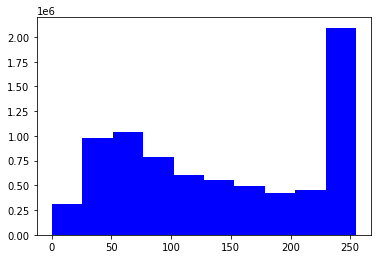

In [ ]:
img1 = Image.open(data_dir + 'train-0'+ str(2).zfill(2) +'.jpg')
img1 = np.asarray(img1)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.hist(img1_gray.ravel(),color = "b")

In [ ]:
# Imported Ids and images to check the logic and counts.
import glob
train_images = []
train_ids = []
for folder in glob.glob(results_dir + f"train/*"):
  label = folder.split("/")[-1]
  for img in glob.glob(f"{folder}/*"):
    image = cv2.imread(img)
    train_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    train_ids.append(label)
    print(img)

In [ ]:
len(train_ids)

210

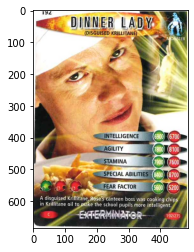

In [ ]:
plt.imshow(train_images[63])